## Analysis of the topics created by the Top2Vec model

- Primitives are loaded, as well as the topic weights of the reduced top2vec model (100 topics) --> see part II in `top2vec_training.ipynb`.
- They are merged into one df.
- Topics are plotted over time in bins per year, using `agg.('mean')`.
- 



In [3]:
import ndjson
import nolds
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d


## Merge representations of reduced model (50) with primitives

In [3]:
import ndjson
import sys
sys.path.append('/work/62138/dutch-chronicles/chronicles/representation')
from document_vectors import RepresentationHandler

In [4]:
from top2vec import Top2Vec

model = Top2Vec.load('/work/62138/models/top2vec/top2vecmodel_50_2')

In [9]:
with open('/work/62138/corpus/primitives_220331/primitives_annotated.ndjson') as fin:
    primitives = ndjson.load(fin)

In [6]:
doc_id2primidx = {doc['id']: i for i, doc in enumerate(primitives)}

In [11]:
rh = RepresentationHandler(model=model, primitives=primitives)

event_cossims = rh.get_primitives_and_cossims(doc_id2primidx[1, n_topics=50)
event_vectors = rh.get_primitives_and_vectors(doc_id2primidx)

TypeError: unhashable type: 'slice'

### Observations

- Difference between *topics with high number of documents similar to them* and *topics with high number of cosine similarity*
- What methods can we use to smoothen the signal?
    - `rolling(window).mean()` takes subsequent data points and averages them, but will give weird output when there are large time gaps between two data points.
    - `scipy.ndimage.gaussian_filter1d`, sigma = 2.

### Scaling and smoothening

- We use the original representations of the cosine similarity, ranging from -1 to +1.
- We apply the `TimeSeriesScalerMeanVariance` in `tslearn.preprocessing`.

In [4]:
year_mean_scaled = pd.read_csv('../../corpus/year_mean_scaled.csv', index_col=0)
year_mean_scaled.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1450,-0.272212,1.581187,5.687352,0.470106,1.219626,0.878718,-0.359234,1.503809,2.211649,...,1.360070,0.538550,3.852131,1.723419,-2.332223,1.688561,0.957550,-0.346109,3.647183,1.105196
1,1451,-0.299907,-1.138443,-1.145044,-0.750547,-1.927901,-0.943105,-1.523076,-1.130025,-1.127321,...,-0.186829,-1.938838,-1.518069,0.062274,1.138678,-0.858984,-0.831873,-1.577613,-1.783913,-1.235959
2,1453,-1.630772,-1.292714,1.808157,3.052558,-1.600364,-1.608338,-1.433308,0.611399,1.718354,...,-0.486289,-0.409831,0.822390,1.545176,0.588994,1.384890,1.244834,-1.571017,-0.050993,-1.580335
3,1454,0.346062,0.435455,-0.188963,-0.313646,1.754227,0.215970,0.276811,0.641815,-0.066323,...,0.785294,4.545936,-0.611967,-1.099752,-1.183042,0.165667,0.843971,0.082539,-0.017649,0.562937
4,1455,-0.841500,-0.006961,-0.354175,0.427795,-0.116554,-0.879924,-0.586642,-0.101221,1.314314,...,-0.069171,2.076482,-0.092437,0.179779,-1.078278,0.474620,0.429645,-0.241994,-0.579078,-0.509721


Text(0, 0.5, 'scaled mean cosine similarity')

<Figure size 720x432 with 0 Axes>

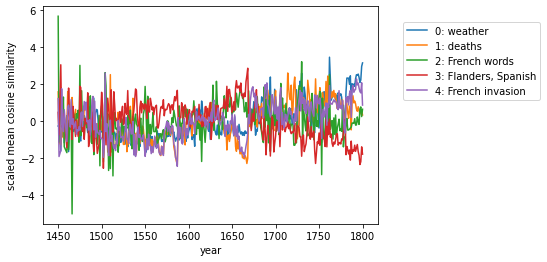

In [6]:
plt.figure(figsize=(10,6))
year_mean_scaled.plot(x='year', y=['0', '1', '2', '3', '4'])
plt.legend(['0: weather', '1: deaths', '2: French words', '3: Flanders, Spanish', '4: French invasion'],
loc='right', bbox_to_anchor=(1.5, 0.75))
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')

### Smoothening with a Gaussian kernel

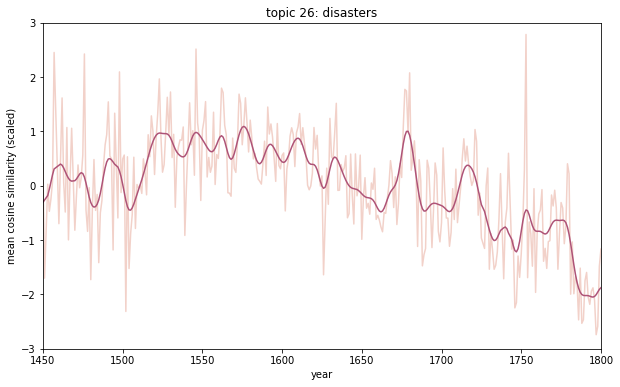

In [5]:
#fig, (axes) = plt.subplots(3, 1, figsize=(4, 12), sharey=False)

topic = [*range(0,100)]
topic = [str(x) for x in topic]

smooth = gaussian_filter1d(year_mean_scaled[topic[26]].to_numpy(), 3)
plt.figure(figsize=(10, 6))
sns.lineplot(year_mean_scaled['year'], year_mean_scaled[topic[26]], color='#F2D1C9')
sns.lineplot(year_mean_scaled['year'], smooth, color='#AE5377')
plt.title('topic 26: disasters')
plt.xlabel('year')
plt.ylabel('mean cosine similarity (scaled)')
plt.xlim([1450, 1800])
plt.ylim([-3, +3])
plt.show()

(-3.0, 3.0)

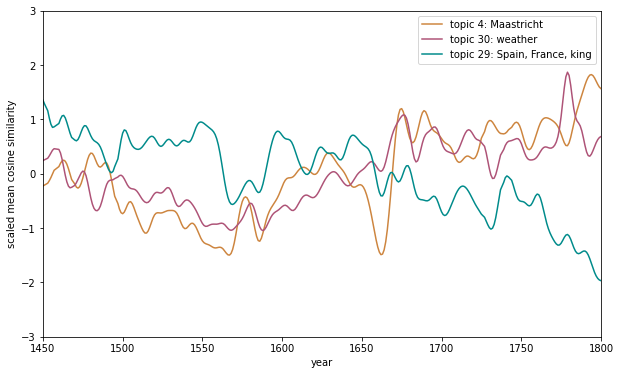

In [15]:
plt.figure(figsize=(10, 6))
smooth0 = gaussian_filter1d(year_mean_scaled[topic[4]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth0, color='peru')
smooth3 = gaussian_filter1d(year_mean_scaled[topic[30]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth3, color='#AE5377')
smooth4 = gaussian_filter1d(year_mean_scaled[topic[29]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth4, color='#008B8B')
plt.legend(['topic 4: Maastricht', 'topic 30: weather', 'topic 29: Spain, France, king'])
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')
plt.xlim([1450, 1800])
plt.ylim([-3, +3])

## DFA (Detrended Fluctuation Analysis)

In [9]:
year_mean = pd.read_csv('../../corpus/year_mean.csv', index_col=0)
year_mean.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1450,-0.017207,0.304431,0.281077,0.205256,0.235938,0.148406,0.114993,0.152635,0.351971,...,0.253335,0.255517,0.395077,0.342056,-0.036096,0.159903,0.296062,0.161600,0.341195,0.238253
1,1451,-0.019187,0.103373,0.014900,0.115983,0.011693,-0.027681,-0.000959,0.023454,0.105956,...,0.127352,0.082901,0.119461,0.192536,0.116945,0.069629,0.162961,0.083724,0.041913,0.002720
2,1453,-0.114332,0.091968,0.129951,0.394125,0.035028,-0.091979,0.007985,0.108865,0.315625,...,0.102964,0.189437,0.239581,0.326012,0.092708,0.149142,0.317431,0.084141,0.137406,-0.031927
3,1454,0.026994,0.219729,0.052147,0.147936,0.274025,0.084349,0.178361,0.110357,0.184130,...,0.206524,0.534737,0.165965,0.087942,0.014574,0.105938,0.287614,0.188706,0.139243,0.183699
4,1455,-0.057906,0.187022,0.045711,0.202162,0.140742,-0.021574,0.092337,0.073914,0.285855,...,0.136935,0.362675,0.192629,0.203113,0.019194,0.116886,0.256796,0.168184,0.108306,0.075783


In [10]:
topic = [*range(0,100)]
topic = [str(x) for x in topic]

nolds.dfa(year_mean[topic[0]])

0.8648973945402135

In [11]:
dfa_list = []

for i in range(0,100):
    dfa_list.append(nolds.dfa(year_mean[topic[i]]))

In [12]:
max_value = max(dfa_list)
min_value = min(dfa_list)

max_index = dfa_list.index(max_value)
min_index = dfa_list.index(min_value)

In [14]:
max_index

4

## Topics

0. weather
1. overleden
2. French words
3. cities Flandres, Spanish
4. Maastricht, French
5. toen, naar, tevens (narrative style)
6. city infrastructure
7. prefect,besluyt, adjointen, communen (city council)
8. aldermen council
9. government
10. stadhuis, kwamen (narrative style about city life?)
11. medieval spelling
12. grondregels, gevoelens, welzyn (wellbeing)
13. coningh (medieval spelling)
14. ande, saude, voorseit (narrative style, stopwords) 
15. keijser, ghecroont, koninck
16. market, cows, cheese
17. lankhorst, brielle
18. Ypere,soldiers
19. stopwords, potatioes, hay, cettle
20. ghestelt, alleene, ghelijck
21. French, guarnijsoen
22. named entities
23. maar, thans, eindelijk
24. vuchterpoort, captijn
25. ooc, hemlien, up
26. disasters
27. garnisoen, Fransen
28. weather
29. Spain, France, king, duke
50: Dutch fleet